# GADF
In this notebook we will experiment with GADF

## Dependencies
pyts
[https://pypi.org/project/TA-Lib/]("https://pypi.org/project/pyts/")

ta
[https://github.com/bukosabino/ta]("https://github.com/bukosabino/ta")

In [52]:
import pandas as pd
import numpy as np

import requests

from dotenv import load_dotenv
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import fastcore.all as fc

from ta import add_all_ta_features
from ta.utils import dropna

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from pyts.image import GramianAngularField

# data util functions
from data import get_data, p2df, zscore_normalize, minmax_normalize, normalize_, create_window

In [53]:
# FOR THIS WE WILL USE THE POLYGON API
load_dotenv()
POLYGON_API_KEY = os.getenv('POLYGON_API_KEY')

In [403]:
# # load some data, we will use TSLA
data = get_data(POLYGON_API_KEY, ticker="SPY", multiplier=30, timespan="minute", from_="2022-01-09", to="2023-02-10", limit=50000)

In [55]:
# def grab_btc(path):
#     # grabbing 2017 btc min data
#     df = pd.read_csv(path)[['date', 'open', 'high', 'low', 'close', 'Volume BTC']]

#     # rename Volumne BTC to volume
#     df.rename(columns={'Volume BTC': 'volume'}, inplace=True)

#     # flip the dataset so that it is in chronological order
#     df = df.iloc[::-1].reset_index(drop=True)
#     return df

In [405]:
# df1 = grab_btc('data/BTC-2017min.csv')
# df2 = grab_btc('data/BTC-2018min.csv')
# df3 = grab_btc('data/BTC-2019min.csv')
# df4 = grab_btc('data/BTC-2020min.csv')
# df5 = grab_btc('data/BTC-2021min.csv')

# df = pd.concat([df1, df2, df3, df4, df5], axis=0).reset_index(drop=True)

In [406]:
# turn our data into a dataframe
df = p2df(data, convert_timestamp=True) # convert timestamp to datetime

In [407]:
# # convert date to datetime
# df['date'] = pd.to_datetime(df['data'], unit='ms')

In [408]:
# # # with our 1min time interval data, we will resample to 3hr intervals
# # df = df.resample('3H', on='date').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})

# # with our 1min time interval data, we will resample to 1D intervals
# df = df.resample('1D', on='date').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})

In [409]:
# # lets grab the first 3 months of 2017
# start_date = '2017-01-01'
# end_date = '2018-01-01'
# df= df.loc[start_date:end_date]

In [410]:
# for our GADF we will first add a lot of TA features
# the only features we are interested in are open, high, low, close, volume so lets clear the rest
df = df[['open', 'high', 'low', 'close', 'volume']]
df.head()

,open,high,low,close,volume
0,466.50,466.68,465.85,466.68,15308.0
1,466.74,466.86,466.22,466.22,5440.0
2,466.00,466.80,465.95,466.20,7542.0
3,466.24,466.34,465.72,465.82,5621.0
4,465.95,465.95,465.33,465.33,5382.0


In [411]:
# lets drop any na values, there shouldnt be any with polgyon data
df = dropna(df)

In [412]:
# lets now add all the ta features
df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [413]:
df

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,466.500,466.6800,465.850,466.680,15308.0,1.530800e+04,15308.0,1.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,466.680000,5.361204,0.000000,0.000000
1,466.740,466.8600,466.220,466.220,5440.0,9.868000e+03,9868.0,0.475612,-2.502400e+03,3235.294118,...,-0.007864,-0.001573,-0.006291,-5.400212,-1.080042,-4.320169,466.556241,-0.098569,-0.098617,-0.098569
2,466.000,466.8000,465.950,466.200,7542.0,6.762471e+03,2326.0,0.239041,-2.166463e+03,-1859.586317,...,-0.014278,-0.004114,-0.010164,-8.731437,-2.610321,-6.121116,466.461493,-0.004290,-0.004290,-0.102854
3,466.240,466.3400,465.720,465.820,5621.0,2.954696e+03,-3295.0,0.087131,-2.162108e+03,-3805.372709,...,-0.025640,-0.008419,-0.017221,-12.741628,-4.636583,-8.105045,466.282514,-0.081510,-0.081543,-0.184280
4,465.950,465.9500,465.330,465.330,5382.0,-2.427304e+03,-8677.0,-0.061774,-2.229976e+03,-4492.753623,...,-0.042634,-0.015262,-0.027372,-16.284945,-6.966255,-9.318690,466.006870,-0.105191,-0.105246,-0.289277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,451.070,452.3078,450.800,451.990,4627305.0,2.949195e+08,22632473.0,-0.157299,-1.760426e+06,-8.182054,...,-0.202634,-0.184152,-0.018483,-0.018201,-27.823990,27.805789,452.983986,0.197295,0.197101,-3.147767
1838,451.985,452.4300,451.565,451.695,2959783.0,2.928494e+08,19672690.0,-0.253813,-1.633671e+06,12.964261,...,-0.211304,-0.189582,-0.021722,0.509943,-22.157204,22.667146,452.788341,-0.065267,-0.065288,-3.210980
1839,451.690,451.7500,450.110,450.350,5265960.0,2.891247e+08,14406730.0,-0.345226,-2.412106e+06,-33.245600,...,-0.239408,-0.199547,-0.039861,7.048939,-16.315975,23.364914,452.301901,-0.297767,-0.298212,-3.499186
1840,450.330,450.5100,449.670,450.430,3067914.0,2.916083e+08,17474644.0,-0.228312,-2.032457e+06,-22.999341,...,-0.257329,-0.211104,-0.046225,6.204162,-11.811948,18.016110,451.966308,0.017764,0.017762,-3.482043


In [414]:
# # let's remove some features
# remove = ['trend_psar_up', 'trend_psar_down']
# df.drop(columns=remove,axis=1,inplace=True)

In [415]:
# window_size = 2
# target = df['close'].rolling(window_size).apply(lambda x: (x[-1] - x[0]) / x[0], raw=True).values

# creating windows 1 month with 1d intervals
window_size = 12
target = df['close'].rolling(window_size).apply(lambda x: (x[-1] - x[0]) / x[0], raw=True).values

In [416]:
# lets scale our data, not including our target
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df.values)
data_normalized = scaler.transform(df.values)

In [417]:
target.shape, data_normalized.shape

((1842,), (1842, 91))

In [418]:
from dataclasses import dataclass

In [419]:
class Data:
    def __init__(self, data, target): self.data, self.target = data, target
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.target[i]

In [420]:
data = Data(data_normalized, target)

In [421]:
def create_window(data, start=0, size=28):
    """Create a window of data"""
    x, y = data[start:start+size]
    return {'data': x, 'target': y[-1]}

In [422]:
window = create_window(data, start=1, size=window_size)
window['data'].shape

(12, 91)

In [423]:
# create window sliding with stride of 1
windows = [create_window(data, start=i, size=window_size) for i in range(len(data)-window_size)]
len(windows)

1830

In [424]:
# create a split of windows to train and test
train_split = int(len(windows) * 0.8)
train_windows = windows[:train_split]
test_windows = windows[train_split:]

In [425]:
gasf = GramianAngularField(image_size=28, method='summation')
gadf = GramianAngularField(image_size=28, method='difference')

In [426]:
# lets create our CNN dataset class
class CNNDataset(Dataset):
    def __init__(self, windows, transform_fn=gasf, conv3d=False):
        self.conv3d = conv3d
        self.X = [transform_fn.fit_transform(window['data']) for window in windows]
        self.y = [window['target'] for window in windows]

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float)
        # reshape for conv3
        if self.conv3d: x = x[None, :, :, :]
        y = torch.tensor(self.y[idx], dtype=torch.float).unsqueeze(0)
        return x, y

In [427]:
from dataclasses import dataclass

In [428]:
@dataclass
class Dls:
    train: DataLoader
    valid: DataLoader

In [429]:
conv3d = True

train_ds = CNNDataset(train_windows, conv3d=conv3d, transform_fn=gadf)
valid_ds = CNNDataset(test_windows, conv3d=conv3d, transform_fn=gadf)

In [430]:
# create our dataloaders
dls = Dls(
    train = DataLoader(train_ds, batch_size=32, shuffle=True),
    valid = DataLoader(valid_ds, batch_size=32, shuffle=False))

In [431]:
xb, yb = next(iter(dls.train))

In [432]:
xb.shape, yb.shape

(torch.Size([32, 1, 12, 28, 28]), torch.Size([32, 1]))

In [433]:
def_device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
def_device = 'cpu' if conv3d else def_device

def to_device(data, device=def_device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)): return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [434]:
class Learner:
    """This is our main class that will be responsible to experimenting and training various models. It serves the purpose of being a vehicle to experiment quickly"""
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        """
        model: <PyTorch Model> the model we are going to train
        dls: <Pytorch DataLoader> the dataloaders we are going to use
        loss_func: <Callable> the loss function we are going to use
        lr: <float> the learning rate we are going to use
        opt_func: <PyTorch optimizer (can be custom)> the optimizer we are going to use
        """
        fc.store_attr() # easy method to store all attributes, prevents mistakes

    def one_batch(self):
        """This method is responsible for one batch of training/evaluation"""
        self.xb, self.yb = to_device(self.batch) # move batch to device
        self.preds = self.model(self.xb) # get predictions
        self.loss = self.loss_func(self.preds, self.yb) # calculate loss
        if self.model.training:
            self.loss.backward() # calculate gradients
            self.opt.step() # update weights
            self.opt.zero_grad() # zero gradients
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        """This method is responsible for calculating statistics"""
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.model.training = train # set model to training mode or evaluation mode
        dl = self.dls.train if train else self.dls.valid # get the correct dataloader
        for self.num, self.batch in enumerate(dl): 
            self.one_batch() # call one_batch method, self.batch will be set to the current batch
        n = sum(self.ns)
        print(f"Epoch: {self.epoch+1}", 'train' if self.model.training else 'valid', f"Loss: {sum(self.losses).item()/n}")
    
    def fit(self, n_epochs):
        """Very lightweight fit method, this is the highest level to train a model via the Learner object"""
        self.losses, self.ns = [], []
        self.model.to(def_device) # place model on appropriate device TODO: Allow this to be changed via fit calls if necessary
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr) # create optimizer
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True) # training
            self.one_epoch(False) # evaluation

In [435]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [436]:
# # Let's now create a simple cnn
# simple_cnn = nn.Sequential(
#     conv(20, 4),
#     conv(4, 8),
#     conv(8, 16),
#     conv(16, 16),
#     conv(16, 1, act=False),
#     nn.Flatten() # flatten our conv output to feed into a linear layer
# )

In [437]:
class SimpleCNN2D(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        batch_size, channels, height, width = input_shape
        self.conv_layers = nn.Sequential(
            conv(channels, 16),
            conv(16, 32),
            conv(32, 64),
            conv(64, 64),
            conv(64, 1, act=False),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

class SimpleCNN3D(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(SimpleCNN3D, self).__init__()
        batch_size, channels, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 64),
            activation(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
class TinyCNN(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(TinyCNN, self).__init__()
        _, _, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 16),
            activation(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

In [459]:
# # create a simple 2d cnn
# simple_cnn = SimpleCNN2D(xb.shape)
# create a simple 3d cnn
simple_cnn = TinyCNN(xb.shape, activation=nn.GELU)

In [460]:
# number of parameters
sum(p.numel() for p in simple_cnn.parameters() if p.requires_grad)

41361

In [461]:
learn = Learner(simple_cnn, dls, nn.MSELoss(), lr=0.01, opt_func=optim.RAdam)

In [462]:
learn.fit(30)

Epoch: 1 train Loss: 0.00849320328300768
Epoch: 1 valid Loss: 0.006979586908726093
Epoch: 2 train Loss: 0.003931517447568318
Epoch: 2 valid Loss: 0.0035454367027908077
Epoch: 3 train Loss: 0.002548788786865044
Epoch: 3 valid Loss: 0.0023823939603100273
Epoch: 4 train Loss: 0.001888299146053741
Epoch: 4 valid Loss: 0.0017952255863960974
Epoch: 5 train Loss: 0.0015008868632637954
Epoch: 5 valid Loss: 0.001441986000603014
Epoch: 6 train Loss: 0.0012474246049345111
Epoch: 6 valid Loss: 0.0012066696945218223
Epoch: 7 train Loss: 0.0010672929163570767
Epoch: 7 valid Loss: 0.0010375762897762444
Epoch: 8 train Loss: 0.0009330828617112516
Epoch: 8 valid Loss: 0.0009102859783693741
Epoch: 9 train Loss: 0.0008296199065207014
Epoch: 9 valid Loss: 0.000811917722478518
Epoch: 10 train Loss: 0.0007473696324423004
Epoch: 10 valid Loss: 0.0007329258111005273
Epoch: 11 train Loss: 0.0006796474568734307
Epoch: 11 valid Loss: 0.0006677332412408941
Epoch: 12 train Loss: 0.00062342410817614
Epoch: 12 valid 

In [463]:
# # save our model
# torch.save(simple_cnn.state_dict(), "simple_cnn_tsla_3.pth")

In [468]:
# saving our model
torch.save(simple_cnn.state_dict(), "simple_cnn_spy_3_tiny.pth")

In [464]:
# # load our model
# simple_cnn.load_state_dict(torch.load("simple_cnn_tsla.pth"))

In [465]:
# let's run some predictions, we will plot the predictions and the actual values
def plot_preds(preds, yb):
    plt.plot(preds, label="preds")
    plt.plot(yb, label="actual")
    plt.legend()

In [466]:
def predict_plot(xb, yb, model):
    # move to device
    xb, yb = to_device(xb), to_device(yb)
    if isinstance(model, nn.Module): model = to_device(model)

    # get predictions
    preds = model(xb)

    # plot predictions
    with torch.no_grad(): plot_preds(preds.squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

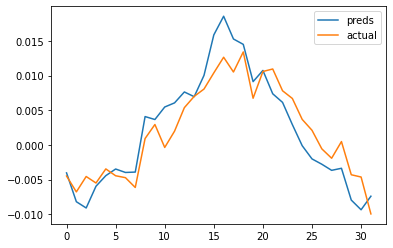

In [467]:
"""GELU Activation 30 epochs, TINY CNN"""
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

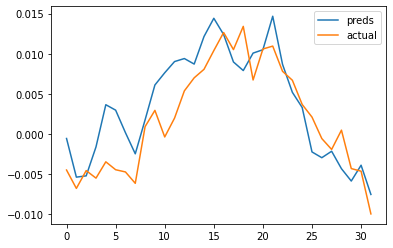

In [453]:
"""GELU Activation 14 epochs, TINY CNN"""
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

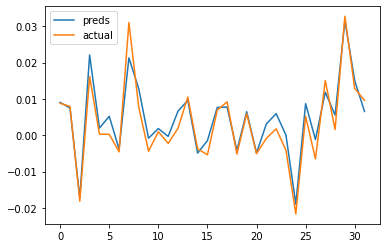

In [454]:
# plot predictions
xb, yb = next(iter(dls.train))
predict_plot(xb, yb, simple_cnn)

In [ ]:
from functools import partial

In [ ]:
def load_model(path, cnn):
    # load our model
    cnn.load_state_dict(torch.load(path))
    cnn.eval()
    return cnn

def ensemble(models, xb):
    models = [to_device(m) for m in models]
    outs = 0
    for model in models:
        outs += model(xb)
    return outs/len(models)

In [ ]:
model1 = nn.Sequential(conv(20, 4), conv(4, 8), conv(8, 16), conv(16, 16),
    conv(16, 1, act=False), nn.Flatten())
model1.load_state_dict(torch.load("./model_weights/simple_cnn_tsla.pth"))

<All keys matched successfully>

In [ ]:
model2 = nn.Sequential(conv(20, 4), conv(4, 8), conv(8, 16), conv(16, 16),
    conv(16, 1, act=False), nn.Flatten())
model2.load_state_dict(torch.load("./model_weights/simple_cnn_tsla_2.pth"))

<All keys matched successfully>

In [ ]:
model3 = nn.Sequential(conv(20, 4), conv(4, 8), conv(8, 16), conv(16, 16),
    conv(16, 1, act=False), nn.Flatten())
model3.load_state_dict(torch.load("./model_weights/simple_cnn_tsla_3.pth"))

<All keys matched successfully>

In [ ]:
# plot predictions
xb, yb = next(iter(dls.valid))

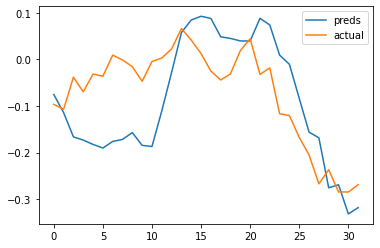

In [ ]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, model1)

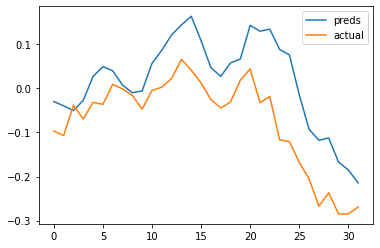

In [ ]:
# plot predictions
predict_plot(xb, yb, model2)

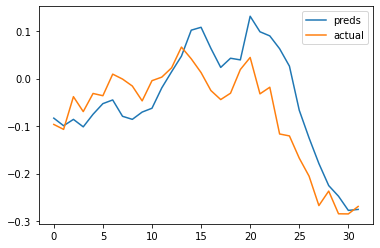

In [ ]:
# plot predictions
predict_plot(xb, yb, model3)

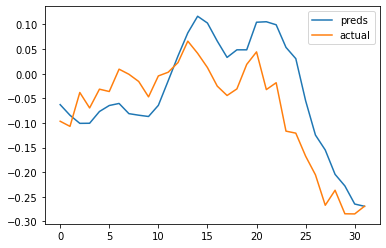

In [ ]:
predict_plot(xb, yb, model=partial(ensemble, [model1, model2, model3]))